<a href="https://colab.research.google.com/github/tedteske/CRE_Monte_Carlo/blob/master/DerbySim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pinewood Derby Simulator

For reference, formulas:
* https://en.wikibooks.org/wiki/How_To_Build_a_Pinewood_Derby_Car/Physics#Friction_forces #most used source
* https://en.wikibooks.org/wiki/How_To_Build_a_Pinewood_Derby_Car/Physics#Motion_with_friction
* https://en.wikibooks.org/wiki/How_To_Build_a_Pinewood_Derby_Car/Physics#Rotational_kinetic_energy
* http://www.pinewoodderbyphysics.com/
* https://www.mech-sci.net/3/73/2012/ms-3-73-2012.pdf formula (8) here appears to support the fomula used in the simulation for adjusting kinetic friction for mechanical advantage
* https://aapt.scitation.org/doi/10.1119/1.2342889

info on the lognormal probability distribution
* https://www.statisticshowto.datasciencecentral.com/lognormal-distribution/
* https://www.itl.nist.gov/div898/handbook/eda/section3/eda3669.htm

empirical data on friction:
* http://www.pinewoodderbyphysics.com/pdf%20files/Lecture%206.pdf
* http://pinewoodderbyphysics.netfirms.com/pdf%20files/Lecture%2013.pdf   #friction between wheel and axle
* https://www.hamiltoncaster.com/Portals/0/blog/White%20Paper%20Rolling%20Resistance.pdf  #rolling resistance

wheel specs:
* http://pinewoodderbyonline.com/threads/stock-wheel-and-axle-weight.4564/
* http://www.pinewoodderbyphysics.com/pdf%20files/Lecture%2026.pdf
* http://www.pinewoodderbyphysics.com/pdf%20files/Lecture%203.pdf

track specs:
* http://www.pinewoodderbyphysics.com/pdf%20files/Lecture%2020.pdf
* http://www.besttrack.com/track_specs.html

to do: precision as significant digits rather than decimal places to which output is rounded, see round_to_n function example at 
* https://stackoverflow.com/questions/3410976/how-to-round-a-number-to-significant-figures-in-python

### Import libraries, and create a class `derby` to hold track specs and a function to simulate a run down the track.

In [1]:
import math
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')
import warnings 
warnings.simplefilter('ignore')
%matplotlib inline
import copy

In [2]:
class derby:

    def __init__(self, d1, d2, d3, incline, lat=35, precision=4, actuals=[]):
        '''
        Initialize derby track.
       
        Parameters
        ----------
        d1 : float, list, or tuple; to be converted to float, 
            length in meters of stage 1 (inclined plane)
        d2 : float, list, or tuple; to be converted to float, 
            length in meters of stage 2 (curved transition) 
        d3 : float, list, or tuple; to be converted to float, 
            length in meters of stage 3 (horizonatal) 
        incline : float, degrees inclination of stage 1 
        lat : float, degrees latitude of derby location
        precision : int, number of decimal places to which output is rounded
        actuals : list, actual result times against which simulation is compared       
        '''
        
        self.d1 = self.convert(d1)
        self.d2 = self.convert(d2)
        self.d3 = self.convert(d3)
        self.theta = math.radians(incline)
        self.g = (lat * 0.00084) + 9.7683
        self.precision = precision
        self.actuals = actuals
        self.simulated = []
        
    def convert(self, x):
        '''
        Draw random number from normal or lognormal distribution and convert 
        to metric system scalar.
       
        Parameters
        ----------
        x : float, list, or tuple; number to be converted
            if tuple or list and last element is str, unit : 
                convert from unit (e.g. ounces) to metric equivalent 
                (e.g. grams)
            if tuple or list and 2 number elements : loc, scale of normal 
                distribution
            if tuple or list and 3 number elements : loc, scale, shape of 
                lognormal distribution
        
        Returns
        ------- 
        float, metric system scalar 
        '''
        
        unit = False
        if isinstance(x, (list, tuple)):
            if isinstance(x[-1], str):
                unit = x[-1]
                x = x[:len(x)-1]
            if len(x) == 3:
                if x[1]>=0:
                    x = stats.lognorm.rvs(loc=x[0], scale=x[1], s=max(x[2],0.1))
                else:
                    x = x[0] - stats.lognorm.rvs(loc=0, scale=-x[1], 
                                                 s=max(x[2],0.1))
            elif len(x) == 2:
                x = stats.norm.rvs(loc=x[0], scale=x[1])
            else: x = x[0]
                    
        if unit:
            conversion_factors = {'feet':0.3048, 'inches':0.0254, 
                                  'ounces':28.3495} #to meters and grams
            try: x = x * conversion_factors[unit]
            except: return x
    
        return x
        
    def print_stats(self):
        '''
        Print usual statistics and fit results to a lognormal distribution.
        '''
        
        try:
            times_dict = {'simulated':self.simulated, 'actuals':self.actuals}
            stats_dict = {}
            for x in times_dict:
                if len(times_dict[x])>0:
                    times_dict[x]  = pd.Series(times_dict[x])
                    usual_stats = times_dict[x].describe()
                    logfit = pd.Series(stats.lognorm.fit(times_dict[x]), name=x)
                    logfit.rename({0:'s = shape',
                                   1:'loc = lower bound', 
                                   2:'scale = distance from '\
                                     'lower bound to median'}, 
                              axis='index', inplace=True)
                    full_stats = pd.concat([usual_stats, logfit], 
                                           keys=['usual stats', 
                                                 'lognormal fit',])
                    full_stats.name=x
                    stats_dict[x] = full_stats
            stats_df = pd.concat(stats_dict, axis=1)

            return stats_df.round(self.precision)
        
        except: print('No data. Run simulation (with write=True)'\
                      'and/or load actuals first.')
    
    def ks_test(self, verbose=True):
        statistic, pvalue = stats.ks_2samp(self.simulated, self.actuals)
        if verbose:
            print('Kolmogorov-Smirnov test that simulated and actual drawn '\
                  'from the same underlying distribution:')
            print('========================================================='\
                  '=====================================')
            print(f'p-value = {pvalue.round(self.precision)}')
            if pvalue > 0.05:
                print('Since the p-value above > 5%, we cannot reject the '\
                      'null hypothesis that')
                print('simulated and actual times are drawn from the same '\
                      'underlying distribution.')
        else: return pvalue
    
    def plot(self):
        '''
        Plot a histogram of the results. 
        '''
        plt.figure(figsize=(10, 7))
        sns.set(font_scale=1.2)
        
        if len(self.simulated) > 0:
            sns.distplot(self.simulated, color='orange', 
                         axlabel='Distribution of Simulated Times')
        if len(self.actuals) > 0:
            sns.distplot(self.actuals, color='steelblue', 
                         axlabel='Distribution of Simulated (orange) '\
                                 'vs Actual (blue) Times')    
    
    def report(self):
        '''
        Combines stats and histogram of the results. 
        '''
        
        if len(self.actuals) > 0:
            print('Comparing Simulated and Actual Times')
            print(self.print_stats(),'\n')
            self.ks_test()
        else:
            print('Simulation Statistics')
            print(self.print_stats(),'\n')
        self.plot()
    
    def acceleration(self, theta, m_car, wheels, m_wheel, r_inner, r_outer, 
                     ckf_w=0, ckf_r=0, crf=0):     
        '''
        Takes arguments sent to self.simulate() and returns acceleration for 
        each stage of the track.
        '''
        
        alpha_w = 1 - wheels * m_wheel/m_car
        alpha_r = 1 + 0.58 * wheels * m_wheel/m_car 
        #0.58 is moment of inertia coefficient, estimated

        mechanical_advantage = r_outer/r_inner
        ckf_w = ckf_w/mechanical_advantage 
        #ckf, adjusted for mechanical advantage
        
        friction = ckf_w * alpha_w  + crf + ckf_r
        
        return self.g * (math.sin(theta) - (math.cos(theta) * friction))/alpha_r
    
    def simulate(self, runs=1, show=True, write=True,
                 m_car=[5,'ounces'], wheels=4, m_wheel=2.636, 
                 r_inner = 0.113, r_outer = 1.515, 
                 ckf_w=0, ckf_r=0, crf=0, cog_adj=0): 
        '''
        Simulate a Pinewood Derby run or runs.
       
        Parameters
        ----------
        runs : int, number of individual race times to be simulated
        show : bool, if True, return result time
        write : bool, if True, write result time(s) to list self.simulated
        m_car : float, mass of car, by default in ounces
        m_wheel : float, mass of each wheel, not counting the axle, 
            by default in grams
        wheels : float, number of wheels per car
        r_inner, r_outer : float, inner and outer radius of wheel, 
            in same unit, by default in cm
        ckf_w : float, coefficient of kinetic (sliding) friction, 
            between wheel and axle
        ckf_r : float, coefficient of kinetic (sliding) friction, 
            between car and rails
        crf : float, coefficient of rolling friction, or rolling resistance
        cog_adj : float, rearward adjustment to center of gravity in meters
        
        Returns
        -------
        if show is True : float, time to finish line in seconds
        '''
        
        results = [] #set up empty list to hold our run results
        for i in range(int(runs)):
            m_wheel_, m_car_ = self.convert(m_wheel), self.convert(m_car) 
            wheels_ = self.convert(wheels)
            r_inner_, r_outer_ = self.convert(r_inner), self.convert(r_outer)
            cog_adj_ = self.convert(cog_adj)
            ckf_w_, ckf_r_ = self.convert(ckf_w), self.convert(ckf_r)
            crf_ = self.convert(crf)

            #stage 1: inclined plane
            a1 = self.acceleration(self.theta, m_car_, wheels_, m_wheel_, 
                                   r_inner_, r_outer_, ckf_w_, ckf_r_, crf_)
            d1 = self.d1 + cog_adj_
            t1 = (2 * d1/a1)**0.5

            #stage 2: curved incline
            v1 = t1 * a1
            a2 = self.acceleration(self.theta/2, m_car_, wheels_, m_wheel_, 
                                   r_inner_, r_outer_, ckf_w_, ckf_r_, crf_) 
            v2 = (v1**2 + 2*a2*self.d2)**0.5
            t2 = 2 * self.d2/(v1 + v2)

            # stage 3: horizontal
            a3 = self.acceleration(0, m_car_, wheels_, m_wheel_, r_inner_, 
                                   r_outer_, ckf_w_, ckf_r_, crf_) 
            d3 = self.d3 - cog_adj_
            v3 = (v2**2 + 2*a3*self.d3)**0.5
            t3 = 2 * d3/(v2 + v3)  #note: = d3/v2 when frictionless

            t_total = round(t1 + t2 + t3, self.precision)
            
            if not math.isnan(t_total): results.append(t_total)
                
        if write: self.simulated = results
        if show: 
            if len(results)==1: results = results[0]
            return results
        
    def simulate_rounds(self, rounds=10, 
                        report_round=None, nudge_round=None, **kwargs):
        ''' 
        Simulate one or more rounds of one or more runs per round.
       
        Parameters
        ----------
        rounds : int, number of rounds
        report_round : int or None
            if None, return table of simulated rounds or nudge round
            if int, return report of summary statistics and comparison 
                to actuals for a particular round
        nudge_round : list, tuple, or None
            if None, return table of simulated rounds 
                or report a particular round
            if list or tuple, 
                first item (item 0) = round to be nudged
                second item (item 0) = standard deviation, 
                    as a proportion of loc, 
                    that each non-loc parameter is to vary
        **kwargs : arbitrary keyword arguments: 
            parameters to be passed on to self.simulate()
        
        Returns
        -------
        see report_round parameter
        '''         
        def convert_and_round(x):
            return self.convert(x).round(self.precision)

        if report_round is None and nudge_round is None:
            df = pd.DataFrame()
            for i in range(rounds):
                kwargs_ = copy.deepcopy(kwargs)
                for key, value in kwargs_.items():
                    if isinstance(value, (list, tuple)): 
                        for i, x in enumerate(value):
                            if isinstance(x, (list, tuple)): 
                                kwargs_[key][i] = convert_and_round(x)

                self.simulate(**kwargs_)

                kwargs_['count'] = len(self.simulated)      
                kwargs_['p-value'] = self.ks_test(verbose=False)
                df = df.append(kwargs_, ignore_index=True)
                df = df[[*kwargs_]] 
                #unpack kwargs_ keys as list to order df columns
                self.simulated_rounds = df.sort_values(by='p-value', 
                                                       ascending=False)
            return self.simulated_rounds
        
        elif isinstance(nudge_round, (list, tuple)): 
            nudge = nudge_round[1]
            newdict = self.simulated_rounds.loc[nudge_round[0]].to_dict()
            del newdict['p-value']
            del newdict['count']
            for key, value in newdict.items():
                if isinstance(value, (list, tuple)):
                    for i in [1,2]:
                        try:
                            j = newdict[key][i]
                            newdict[key][i] = [j, abs(j * nudge)]
                        except: pass
            return self.simulate_rounds(rounds=rounds, **newdict)
        
        else:
            newdict =  self.simulated_rounds.loc[report_round].to_dict()
            del newdict['p-value']
            del newdict['count']
            self.simulate(show=False, **newdict)
            self.report()
            

### OKC Pack 27 Individual Time Simulations

Create an instance of the class `derby` matching pack 27's track: the 42' BestTrack here http://www.besttrack.com/track_specs.html

In [3]:
pack27 = derby([7,'feet'],[41,'inches'],[28,'feet'],26) 
#i.e. 7' staight ramp with 26-degree incline, 41" curved portion, 28' horizontal

Simulate a run involving 0 friction, 0 energy used spinning wheels, and a center of gravity just inside the back axle. This is the theoretically fastest time on the track.

In [4]:
pack27.simulate(wheels=0, ckf_w=0, ckf_r=0, crf=0, cog_adj=0.055)

2.9898

Simulate the 0 friction case but factor in energy used to spin wheels. This is the fastest possible time with stock wheels.

In [5]:
pack27.simulate(wheels = 4, m_wheel=2.636, 
                ckf_w=0, ckf_r=0, crf=0, cog_adj=0.055)

3.0537

Now assume that one wheel is lifted off the track. If that is allowed, this is instead the fastest possible time with stock wheels.

In [6]:
pack27.simulate(wheels = 3, m_wheel=2.636, 
                ckf_w=0, ckf_r=0, crf=0, cog_adj=0.055)

3.0378

Now assume (possibly illegal) speed wheels like these: 
https://www.maximum-velocity.com/product/outlaw-wheels-4-nickel-speed-axles-5-by-derbyworx/

In [7]:
pack27.simulate(wheels = 3, m_wheel=1.1, 
                ckf_w=0, ckf_r=0, crf=0, cog_adj=0.055)

3.01

Here is a simulation that gets close to the actual Pack 27 winning time of 3.14 secs in 2020. This can be improved with some combination of
* lighter wheels
* wheels with lower rolling resistance (`crf`)
* a center of gravity that is farther back (`cog_adj=0.03` means a center of gravity 3cm rearward from the middle of the car)
* a lower coefficient of kinetic friction `ckf_w` between the wheel and the axle
* a lower coefficient of kinetic friction `ckf_r` between parts of the car touching the rail and the rail

In [8]:
pack27.simulate(wheels = 3, m_wheel=2.636, 
                ckf_w=0.08, ckf_r=0, crf=0.0053, cog_adj=0.03)

3.1248

Here is an example of simulating 6 runs while letting the following variables vary randomly:
* the coefficient of kinetic friction `ckf_w` between the wheel and the axle, and
* the center of gravity adjustment `cog_adj`

In [9]:
pack27.simulate(runs=6, wheels=4, m_wheel=2.636, 
                ckf_w=[0.06,0.04,0.8], crf=0.0053, cog_adj=[0.01,0.01])

[3.1854, 3.1502, 3.1979, 3.1554, 3.1379, 3.1381]

In the line above, the variable assignment `cog_adj=[0.01,0.01]` means that the center of gravity adjustment follows a normal probability distribution (i.e. a bell curve) with mean and standard deviation both equal to 0.01. When you run the line above, 6 draws are made at random from the distribution and used as the center of gravity adjustment contributing to the six run times. The distribution looks like this:


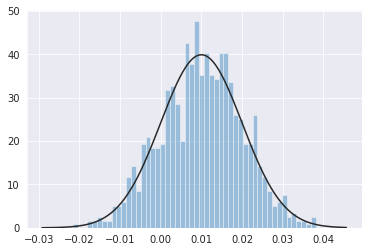

In [10]:
cog_adj=[0.01,0.01]

mean = cog_adj[0]
standard_deviation = cog_adj[1]

dist = []
for i in range(1000):
    x = stats.norm.rvs(loc=mean, scale=standard_deviation)
    dist.append(x)

sns.distplot(dist, bins= 50, fit=stats.norm, kde=False)

The variable assignment `ckf_w=[0.06,0.04,0.8]` means that the coefficient of kinetic (sliding) friction between the wheel and axle follows a lognormal probability distribution with 
* lower bound = 0.06
* the distance from the lower bound to the median = 0.04, and 
* the shape of the distribution = 0.8. 

See here for how the shape parameter impacts the distribution
https://www.statisticshowto.datasciencecentral.com/lognormal-distribution/
https://www.itl.nist.gov/div898/handbook/eda/section3/eda3669.htm

When you run the line above, 6 draws are made at random from the distribution and used as inputs to calculate the six run times. The distribution looks like this:

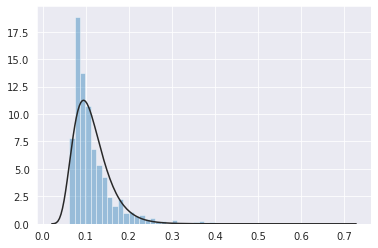

In [11]:
ckf_w=[0.06,0.04,0.8]

floor = ckf_w[0]
median = ckf_w[1]
shape = ckf_w[2]

dist = []
for i in range(1000):
    x = stats.lognorm.rvs(loc=floor, scale=median, s=shape)
    dist.append(x)

sns.distplot(dist, bins= 50, fit=stats.lognorm, kde=False)

### Now we are ready to simulate OKC Pack 27 Race Day: Letting car specs vary randomly and simulating multiple runs.

First, let's load in the actual times from the 2019 prelimary rounds. We'll see how close our simulation can get to the distribution of actual times.

In [12]:
pack27.actuals = [3.3345, 3.3947, 3.8987, 3.1707, 3.4671, 3.6783, 3.6063, 
                  3.5617, 3.3061, 3.1887, 3.4537, 3.325, 3.2297, 3.4305, 
                 3.2234, 3.3049, 3.5084, 3.6927, 3.9371, 3.1629, 3.5765, 
                  3.4617, 3.3243, 3.2499, 3.537, 3.6073, 3.5268, 3.5108, 
                 3.2174, 3.2173, 3.5565, 3.2477, 3.1661, 3.4503, 3.4981, 3.9206, 
                  3.1767, 3.6604, 3.6171, 3.4027, 3.3691, 3.171, 
                 3.4581, 3.2043, 3.3294, 3.3234, 3.2515, 3.571, 3.3818, 3.9779, 
                  3.1644, 3.6554, 3.2073, 3.507, 3.706, 3.7046, 
                 3.524, 3.5849, 3.8685, 3.4643, 3.2563, 3.1564, 3.4699, 3.2096, 
                  3.5435, 3.1754, 3.2103, 3.3805, 3.3541, 3.911, 
                 3.1733, 3.8078, 3.3306, 3.5754, 3.4956, 3.2321, 3.6463, 3.3248, 
                  3.1933, 3.3752, 3.4905, 4.1457, 3.3194, 3.2773, 
                 3.3149, 3.2656, 3.1715, 3.228, 3.3822, 3.4723, 3.3717, 3.4907, 
                  3.964, 3.2865, 3.2415, 3.3732, 3.2431, 3.194, 
                 3.2338, 3.3487, 3.5, 4.0588, 3.5364, 3.5933, 3.3432, 3.2503, 
                  3.3826, 3.2154, 3.2467, 3.2331, 3.3632, 3.4893, 
                 4.0802, 3.2984, 3.6432, 3.3207, 3.2605, 3.3621, 3.1977, 3.3718, 
                  3.71, 3.2787, 3.1708, 3.6621, 4.0157, 3.4766, 
                 3.3816, 3.2951, 3.2537, 3.272, 3.7686, 3.2901, 3.2453, 3.2162, 
                  3.5613, 3.2045, 3.7577, 3.6657, 3.3512, 3.2534, 
                 3.2811, 3.7761, 3.6364, 3.1932, 3.1744, 3.5817, 3.1927, 4.9484, 
                  3.4269, 3.2936, 3.2796, 3.2761, 3.6613, 3.7732, 
                 3.2542, 3.6226, 3.67, 3.1949, 4.5999, 3.6028, 3.3013, 3.2799, 
                  3.2882, 3.754, 3.7163, 3.3539, 3.1738, 3.2049, 
                 3.2088, 4.0982, 3.6486, 3.2735, 3.2694, 3.7146, 3.8732, 3.7433, 
                  3.4618, 3.3425, 3.5404, 4.5139, 4.8603, 3.6335, 
                 3.29, 3.1906, 3.296, 3.6439, 3.7376, 3.402, 3.3767, 3.2768, 
                  3.218, 3.6492, 3.5203, 3.2059, 3.4544, 3.2946, 
                 3.3882, 3.956, 3.3881, 4.0722, 3.3933, 3.2819, 3.487, 3.4115, 
                  3.2072, 3.4183, 3.307, 3.368, 3.3213, 3.3656, 
                 4.2748, 3.3237, 3.322, 3.4415, 3.2418, 3.3804, 3.4118, 3.2542, 
                  3.3696, 3.3262, 4.1394, 3.3447, 3.4351, 3.2576, 
                 3.439, 3.2121, 3.4374, 3.385, 3.3502, 3.4076, 3.3133, 4.0541, 
                  3.3451, 3.4815, 3.2921, 3.4545, 3.226, 3.427, 
                 3.3717, 3.3695, 3.3987, 3.3648, 4.177, 3.3906, 3.3119, 3.2859, 
                  3.3103, 3.196, 3.3408, 3.2823, 3.4573, 3.4274, 
                 3.3172, 3.2449, 3.2924, 3.2756, 3.273, 3.4468, 3.3129, 3.2059, 
                  3.4059, 3.3426, 3.2763, 3.4285, 3.3208, 3.2202, 
                 3.2346, 3.3067, 3.2833, 3.3869, 3.2802, 3.231, 3.2918, 3.2749, 
                  3.4209, 3.2688, 3.5103, 3.5277, 3.3807, 3.6383, 
                 3.3847, 3.1907, 3.326, 3.3078, 3.2171, 3.2561, 3.4034, 3.4015, 
                  3.4129, 3.6345, 3.5952, 3.394, 3.1893, 3.2533, 
                 3.221, 3.2264, 3.2759, 3.4078, 3.6477, 3.4456, 3.5092, 3.4279, 
                  3.6053, 3.469, 3.2576, 3.1806, 3.5231, 3.2294, 
                 3.2164, 3.3088, 3.4325, 3.7363, 3.7257, 3.5332, 3.4443, 3.4136, 
                  3.2079, 3.3237, 3.2255, 3.2911, 3.5768, 3.1756, 3.4643, 3.47]


Now, let's simulate a round and compare the simulated round with the actuals above.

Comparing Simulated and Actual Times
                                                           simulated   actuals
usual stats   count                                         291.0000  324.0000
              mean                                            3.4535    3.4365
              std                                             0.2872    0.2599
              min                                             3.1635    3.1564
              25%                                             3.2693    3.2692
              50%                                             3.3648    3.3707
              75%                                             3.5405    3.5233
              max                                             5.0257    4.9484
lognormal fit s = shape                                       0.8414    0.7767
              loc = lower bound                               3.1454    3.1258
              scale = distance from lower bound to median     0.2178    0.2322 

Kolmogorov-Sm

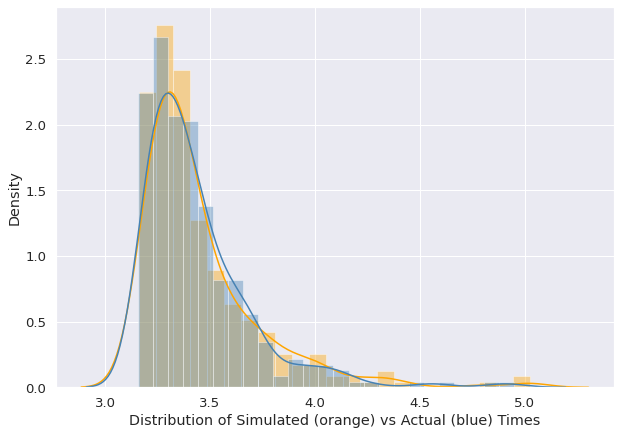

In [13]:
specs = {'m_wheel': 2.636, 
        'm_car': [5,-0.2,0.8,'ounces'], 
         #note: a negative value for the scale param 
         #means loc is a ceiling (rather than floor)
        'ckf_w': [0.06,0.04,0.8],
        'ckf_r': [0,0.025,1], 
        'crf': 0.0053, 
        'cog_adj': [0.01,0.01]}

pack27.simulate(runs=324,show=False, **specs)
pack27.report()

Pretty close, but can we get closer? Simulate 100 rounds of 324 runs each, letting the distributions of car specs vary.

In [14]:
specs = {'m_wheel': 2.636, 
        'm_car': [5,[-0.2,0.02],[0.8,0.08], 'ounces'], 
        'ckf_w': [0.06,[0.04,0.004],[0.8,0.08]],
        'ckf_r': [0,[0.025,0.003],[1,0.1]],
        'crf': 0.0053, 
        'cog_adj': [0.01,[0.01,0.001]]}

pack27.simulate_rounds(rounds=100, runs=324, **specs).head(10)

,runs,m_wheel,m_car,ckf_w,ckf_r,crf,cog_adj,count,p-value
59,324.0,2.636,"[5, -0.2446, 0.8113, ounces]","[0.06, 0.0398, 0.757]","[0, 0.0228, 1.0246]",0.0053,"[0.01, 0.0107]",291.0,0.932880
38,324.0,2.636,"[5, -0.1817, 0.862, ounces]","[0.06, 0.0391, 0.7426]","[0, 0.0218, 0.9834]",0.0053,"[0.01, 0.0114]",295.0,0.909183
81,324.0,2.636,"[5, -0.1803, 0.7215, ounces]","[0.06, 0.0424, 0.7989]","[0, 0.0237, 0.9655]",0.0053,"[0.01, 0.0114]",286.0,0.854355
35,324.0,2.636,"[5, -0.1785, 0.7656, ounces]","[0.06, 0.0332, 0.8612]","[0, 0.0247, 0.96]",0.0053,"[0.01, 0.0105]",297.0,0.846581
48,324.0,2.636,"[5, -0.2151, 0.7804, ounces]","[0.06, 0.0329, 0.7828]","[0, 0.0246, 0.943]",0.0053,"[0.01, 0.0111]",297.0,0.816339
80,324.0,2.636,"[5, -0.1832, 0.8599, ounces]","[0.06, 0.0464, 0.7184]","[0, 0.0237, 1.0434]",0.0053,"[0.01, 0.0095]",284.0,0.810223
52,324.0,2.636,"[5, -0.2019, 0.666, ounces]","[0.06, 0.0431, 0.9026]","[0, 0.0243, 0.9699]",0.0053,"[0.01, 0.0098]",294.0,0.805560
87,324.0,2.636,"[5, -0.1907, 0.8896, ounces]","[0.06, 0.0506, 0.7766]","[0, 0.0228, 0.9049]",0.0053,"[0.01, 0.0096]",304.0,0.734953
21,324.0,2.636,"[5, -0.1883, 0.7569, ounces]","[0.06, 0.0332, 0.7986]","[0, 0.0248, 1.0184]",0.0053,"[0.01, 0.0106]",291.0,0.734555
29,324.0,2.636,"[5, -0.2002, 0.8626, ounces]","[0.06, 0.0342, 0.7237]","[0, 0.0256, 0.9811]",0.0053,"[0.01, 0.0083]",290.0,0.715628


Pick the best round above and nudge the specs a little to see if we can get closer still.

In [15]:
pack27.simulate_rounds(nudge_round=[72,0.001])

,runs,m_wheel,m_car,ckf_w,ckf_r,crf,cog_adj,count,p-value
7,324.0,2.636,"[5, -0.1912, 0.8868, ounces]","[0.06, 0.038, 0.7192]","[0, 0.0235, 1.1543]",0.0053,"[0.01, 0.0121]",281.0,0.363900
0,324.0,2.636,"[5, -0.1916, 0.8866, ounces]","[0.06, 0.038, 0.7193]","[0, 0.0235, 1.1572]",0.0053,"[0.01, 0.0121]",284.0,0.251681
3,324.0,2.636,"[5, -0.1913, 0.8857, ounces]","[0.06, 0.038, 0.7194]","[0, 0.0235, 1.1578]",0.0053,"[0.01, 0.0121]",280.0,0.188584
8,324.0,2.636,"[5, -0.1913, 0.886, ounces]","[0.06, 0.0381, 0.718]","[0, 0.0235, 1.1571]",0.0053,"[0.01, 0.0121]",286.0,0.155289
5,324.0,2.636,"[5, -0.1914, 0.8869, ounces]","[0.06, 0.038, 0.7191]","[0, 0.0235, 1.156]",0.0053,"[0.01, 0.0121]",282.0,0.143280
9,324.0,2.636,"[5, -0.191, 0.8868, ounces]","[0.06, 0.038, 0.7187]","[0, 0.0235, 1.1553]",0.0053,"[0.01, 0.0121]",290.0,0.140254
6,324.0,2.636,"[5, -0.1911, 0.8859, ounces]","[0.06, 0.038, 0.719]","[0, 0.0235, 1.1554]",0.0053,"[0.01, 0.0121]",286.0,0.100329
4,324.0,2.636,"[5, -0.1908, 0.8877, ounces]","[0.06, 0.038, 0.7194]","[0, 0.0235, 1.1583]",0.0053,"[0.01, 0.0121]",281.0,0.045345
2,324.0,2.636,"[5, -0.1914, 0.8875, ounces]","[0.06, 0.038, 0.7189]","[0, 0.0235, 1.1577]",0.0053,"[0.01, 0.0121]",292.0,0.023782
1,324.0,2.636,"[5, -0.191, 0.8854, ounces]","[0.06, 0.038, 0.7186]","[0, 0.0235, 1.156]",0.0053,"[0.01, 0.0121]",277.0,0.005511


Run a report comparing the improved simulation to the actuals.

Comparing Simulated and Actual Times
                                                           simulated   actuals
usual stats   count                                         287.0000  324.0000
              mean                                            3.4878    3.4365
              std                                             0.3519    0.2599
              min                                             3.1582    3.1564
              25%                                             3.2463    3.2692
              50%                                             3.3571    3.3707
              75%                                             3.5696    3.5233
              max                                             5.1050    4.9484
lognormal fit s = shape                                       1.0331    0.7767
              loc = lower bound                               3.1468    3.1258
              scale = distance from lower bound to median     0.2094    0.2322 

Kolmogorov-Sm

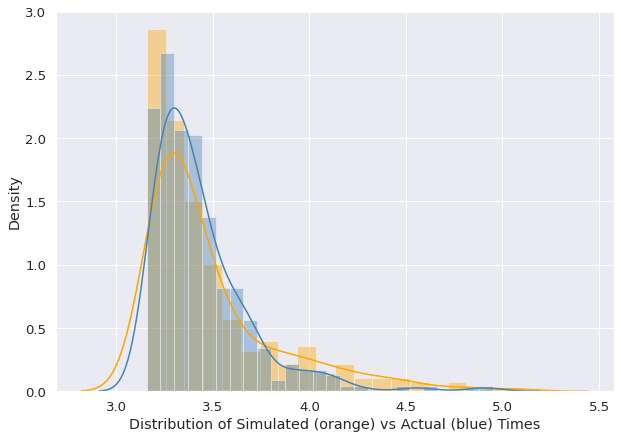

In [16]:
pack27.simulate_rounds(report_round=4)